In [1]:
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from htmresearch.support.cans.utils import *
from htmresearch.support.cans.basic_dynamics import *
%load_ext autoreload
%autoreload 2


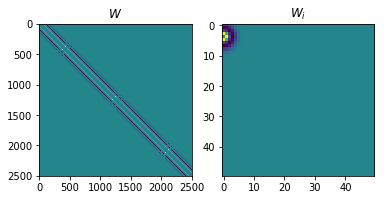

In [18]:

# Set up the shape 
# of the cortical sheet
xy_ratio = 1.

rx  = 30.
ry  = rx*xy_ratio

nx = 50
ny = nx*int(xy_ratio)
n  = nx*ny 


# Positions of neurons on cortical sheet
X = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
X[:,0] *= rx
X[:,1] *= ry

# Distance matrix of neurons
D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
            D[i,j] = np.linalg.norm( X[i] - X[j])

# Function encoding the connection strength 
# based on distance
J = mexican_hat

# Create a weight matrix given J and D
# basiclally J(D) with some normalization...
W = create_W(J, D)


# Visualize
fig, ax = plt.subplots(1,2)
ax[0].imshow(W)
ax[0].set_title("$W$")
i = 200
ax[1].imshow(W[i].reshape((nx,ny)))
ax[1].set_title("$W_{i}$")
plt.show()

# plt.plot(W[200])
# plt.show()



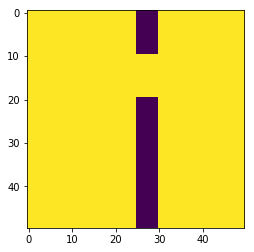

In [20]:
# Creating a mask 
# encoding "topological defects"

mask = np.ones((nx,ny))

mask[0:10,25:30] = 0.

mask[20:,25:30] = 0.
# num_areas = 6
# R = np.array([
#     [15,20],
#     [10,40]
# ])/np.array([[float(nx), float(ny)]])
# R[:,0] *= rx
# R[:,1] *= ry
# print R.shape

# mask = mask.reshape(-1)
# for i in range(n):
#     dist_to_pins = np.amin( np.linalg.norm(R - X[i].reshape((1,2)), axis=1)) 
#     if dist_to_pins < 2:
#         mask[i] = 0.

plt.imshow(mask.reshape((nx,ny)))
mask = mask.reshape(-1)


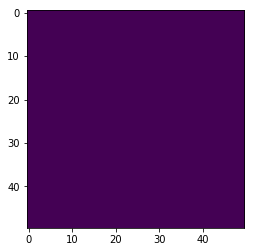

In [21]:
beta_mask = np.ones((nx,ny))*2.
# beta_mask = beta_mask*np.linspace(1.0,4.,num=ny).reshape((1,ny))



# mask[10:20,50:60]    = 0.
# # mask[10:20,115:125]  = 0.


# R = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
# R[:,0] *= rx
# R[:,1] *= ry

# R = R[np.random.choice(n,size=5, replace=False)]

# rnd = np.random.sample(5)

# beta_mask = np.zeros(n)
# for i in range(n):
#     j = np.argmin( np.linalg.norm(R - X[i], axis=1))
#     beta_mask[i] = 2.5 + (rnd[j] - 0.5)*1.

    
plt.imshow(beta_mask.reshape((nx,ny)))
plt.show()
beta_mask = beta_mask.reshape(-1)


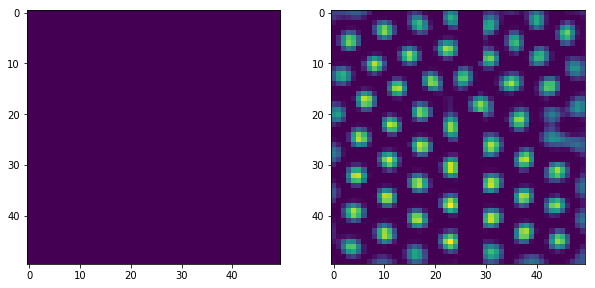

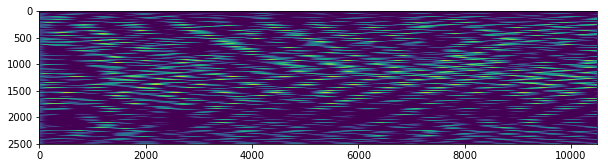

In [22]:
from htmresearch.support.gridcells.utils import cross_correlate
from scipy import ndimage
import numpy.fft as fft
from scipy.special import expit




T = 10500
# X = np.linspace(0.2,0.4,num=T)

S = np.zeros((T,n))




S[0] = np.zeros(n)
# S[0] = np.random.sample(n)*0.001


Beta = np.ones((T,n))*0.0




for t in range(1,T):
    
    s = S[t-1]
    b = np.zeros(n)
    
    tonic = 0.01
    beta  = Beta[t-1]
    
    s_ = evolve_step(W, b  + tonic, s, beta_mask*beta, mask=mask) 
#     s_ = evolve_step(W, b  + tonic, s) 
    S[t]    = s_

    alpha = 0.01
    Beta[t] = (1. - alpha)*Beta[t-1] - alpha*(s_ - np.mean(s_))


fig, ax = plt.subplots(1, 2, figsize=(10, 5));
ax[0].imshow(S[0].reshape((nx,ny)), label="$s_0$")
ax[1].imshow(S[-1].reshape((nx,ny)), label="$s_1$")
plt.show()


plt.figure(figsize=(10,5))
plt.imshow(S.T)
plt.show()





In [26]:

    
S_, V, C = get_data_flow_and_color_maps(S[:], nx,ny, t_step=10)



done


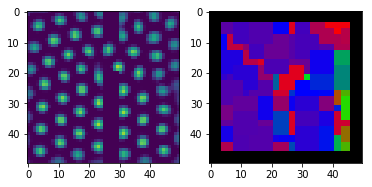

In [27]:
import matplotlib.animation as animation


def update(num, data, a):
    S_, C = data
    a[0].set_data(S_[num].reshape((nx, ny)))
    a[1].set_data(C[num].reshape((nx, ny, 3)))

    return a[0],a[1]




fig, ax   = plt.subplots(1,2)

a0  = ax[0].imshow(S_[0].reshape((nx,ny)), animated=True, vmin=np.amin(S_), vmax=np.amax(S_))
a1  = ax[1].imshow(C[0].reshape((nx,ny,3)), animated=True)

ani = animation.FuncAnimation(fig, update, len(S_), fargs=((S_,C), (a0,a1)),
                                   interval=10, blit=True)

ani.save('moving_bumps_sq_3.mp4')
print "done"
# plt.show()

In [393]:
S_, V, C = get_data_flow_and_color_maps(S[-3000:], nx,ny, t_step=10)


(100, 1600, 3)


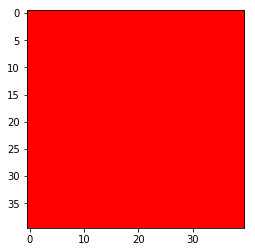

In [396]:
print C.shape

plt.imshow(C[0].reshape((nx,ny, 3)))


(1100, 40, 40)
[ 0.  0.  0. ...,  0.  0.  0.]


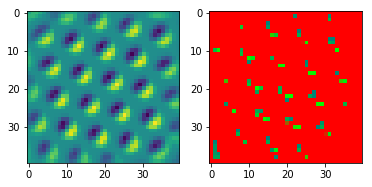

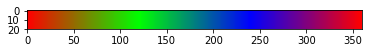

In [435]:
S_ = S[np.arange(0, T, step=5)]
S_ = S_.reshape((-1,nx,ny))  
print S_.shape

V = np.zeros((T,n,2))
V_ = np.zeros((T,n,2))
# S_ = (S_ > 0.02).astype(float)

S__ = S_[10:] - S_[:-10]
for t in range(600,750):

    vx, vy = optical_flow(S__[t], S__[t + 10], window_size=3)
    vx = vx.reshape(-1)
    vy = vy.reshape(-1)


    V[t,:,0] = vx
    V[t,:,1] = vy

for i in range(nx):
    for j in range(ny):
        V_[i,j] = np.



t = 600


mu = V[t]
c = flow_to_color(mu[:,0],mu[:,1])



fig, ax   = plt.subplots(1,2)

# ax[0].imshow(S_[t+10].reshape((nx,ny)) - S_[t].reshape((nx,ny)))
ax[0].imshow(S__[t].reshape((nx,ny)) + S__[t+10].reshape((nx,ny)) )
ax[1].imshow(c.reshape((nx,ny,3)))
plt.show()




theta = np.linspace(0,2*np.pi, num=360)
img =np.zeros((20,360,3))
    
for i in range(20):
    for j in range(360):
        col = cw(theta[j])
        img[i,j] = col

    
plt.imshow(img)
